# End to End Medial Diagnostic Use Case 

Steps of the project:
0. Create a virtual environment with python=3.8.13
1. Import and view the data 
2. Check the data for Sanity
3. Perform EDA on data set 
4. Preprocess the data for modelling
5. Fit and Evlaute various Models
6. Optimize the chosen model
7. Interpret the optimized model
8. Pickle and save the model as a pipeline
9. Deploy the model pipeline in streamlit
10. Scale model to cloud using git and streamlit sharing
    

In [1]:
!pip install imbalanced-learn

In [2]:
!pip install xgboost

In [3]:
!pip install shap

In [4]:
# Load all the librarires
# for data manipulation and visualization 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

# preprocessing modules
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE

# modelling modules
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

# modules for model evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import plot_precision_recall_curve

#for model interpretation
import shap

# deployment module
#import streamlit as st

print("All Libraries are imported")


All Libraries are imported


### 1. Import and view the data 

In [5]:
data=pd.read_csv('data.csv')

In [6]:
data.head()

,Unnamed: 0,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0,6,148,72,35,0,33.6,0.627,50,Yes
1,1,1,85,66,29,0,26.6,0.351,31,No
2,2,8,183,64,0,0,23.3,0.672,32,Yes
3,3,1,89,66,23,94,28.1,0.167,21,No
4,4,0,137,40,35,168,43.1,2.288,33,Yes


In [7]:
data.shape


(768, 10)

###  Check the data for Sanity

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                768 non-null    int64  
 1   Pregnancies               768 non-null    int64  
 2   Glucose                   768 non-null    int64  
 3   BloodPressure             768 non-null    int64  
 4   SkinThickness             768 non-null    int64  
 5   Insulin                   768 non-null    int64  
 6   BMI                       768 non-null    float64
 7   DiabetesPedigreeFunction  768 non-null    float64
 8   Age                       768 non-null    int64  
 9   Outcome                   768 non-null    object 
dtypes: float64(2), int64(7), object(1)
memory usage: 60.1+ KB


In [9]:
data.isnull().sum()

Unnamed: 0                  0
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [10]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,768.0,383.500000,221.846794,0.000,191.75000,383.5000,575.25000,767.00
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00


In [11]:
# check for any other non real characters
data[~data.applymap(np.isreal).any(1)]

,Unnamed: 0,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome


**Observations**
1. Data set has 768 rows and 10 columns( 1 redundant)
2. Dataset has no direct nulls but has nulls imputed as 0
3. Dataset has only 1 categorical variable the Outcome


In [12]:
data.columns

Index(['Unnamed: 0', 'Pregnancies', 'Glucose', 'BloodPressure',
       'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age',
       'Outcome'],
      dtype='object')

In [13]:
# drop the redundant column
data=data.drop('Unnamed: 0', axis=1)

In [14]:
# treat the nulls
zerofiller=lambda x: x.replace(0, x.median())
cols=data.columns[1:6]
data[cols]=data[cols].apply(zerofiller, axis=0)

In [15]:
#encode categoricals
df=data.copy()
d={'Yes':1, 'No':0}
df['Outcome']=df['Outcome'].map(d)

In [16]:
df.head(2)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,30.5,33.6,0.627,50,1
1,1,85,66,29,30.5,26.6,0.351,31,0


### Perform EDA on data set 
1. UNIVARIATES- NUMERICALS
2. UNIVARIATES-CATEGORICALS
3. BIVARIATES-NUMERICAL vs CATEGORICAL
4. BIVARIATES- NUMERICALS VS NUMERICLAS
5. MULTIVARIATE CHARTS 
6. Correlations and Heatmaps 

##### 1. UNIVARIATES

In [17]:
def histograms(data):
    print('Univariate Histogram')
    data.hist()
    plt.tight_layout()
    plt.show()
    

Univariate Histogram


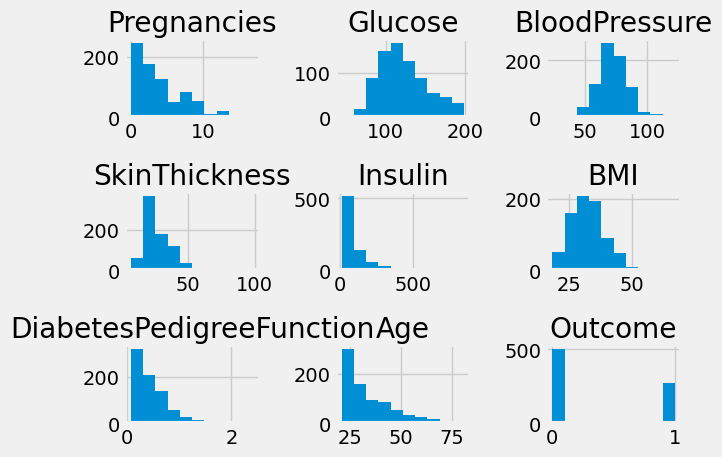

In [18]:
histograms(df)

In [19]:
def barchart(data, feature):
    print("Barchart of Categoricals")
    ax=sns.countplot(data=data, x=feature, color='green')
    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax.annotate("{:.2g}%".format(100.*y/len(data)), (x.mean(),y), ha='center' , va='bottom')                                  
    plt.show()

Barchart of Categoricals


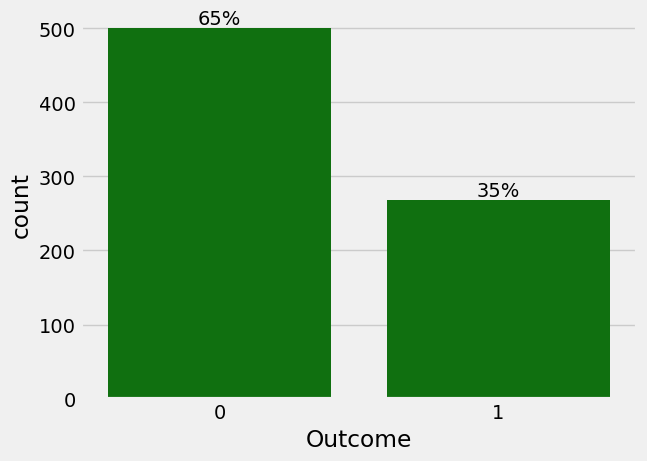

In [20]:
barchart(data=df, feature='Outcome')

**Observations**
Outcome variable is highly imbalanced. We need to solve for data imbalance 

In [21]:
def boxpolot_histplot(data, feature, figsize=(12,7), bins=None):
    print("Univariates of ", feature)
    fig, (ax_box, ax_hist)=plt.subplots(
    nrows=2,
    sharex=True,
    gridspec_kw={'height_ratios':(0.25,0.75)},
    figsize=figsize)
    
    sns.boxplot(data=data,x=feature, showmeans=True, ax=ax_box, color='violet')
    
    sns.histplot(data=data, x=feature, bins=bins, ax=ax_hist, pallete='winter') if bins else\
         sns.histplot(data=data,x=feature, ax=ax_hist)
    plt.axvline(data[feature].mean(),linestyle='--', color='green')
    plt.axvline(data[feature].median(), linestyle='-', color='black')
    plt.show()
    
    
    

Univariates of  Pregnancies


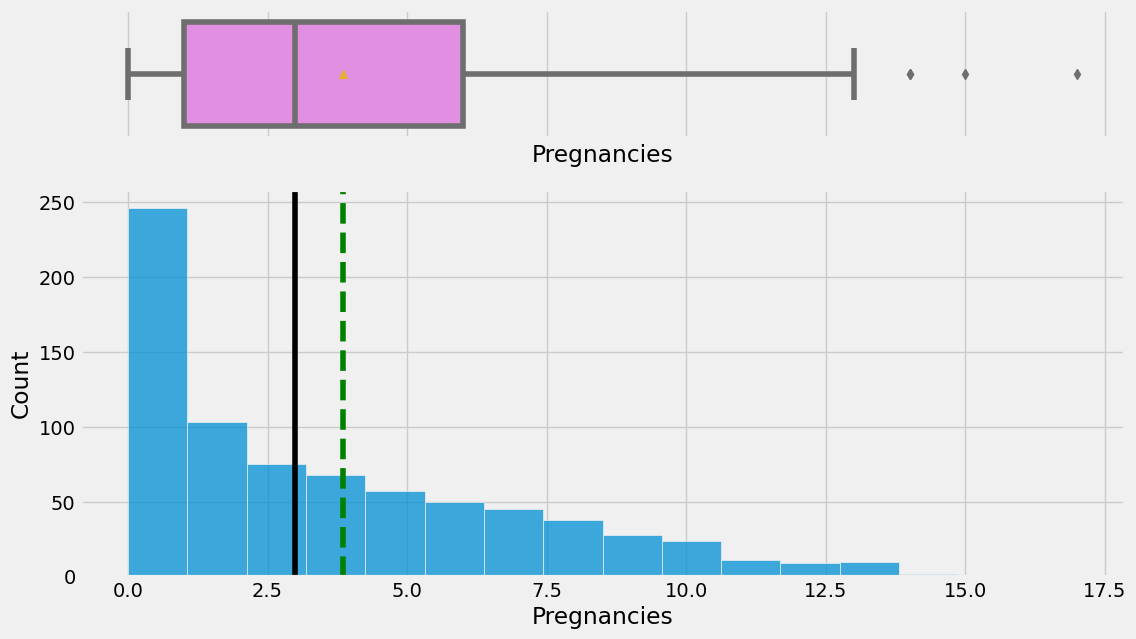

Univariates of  Glucose


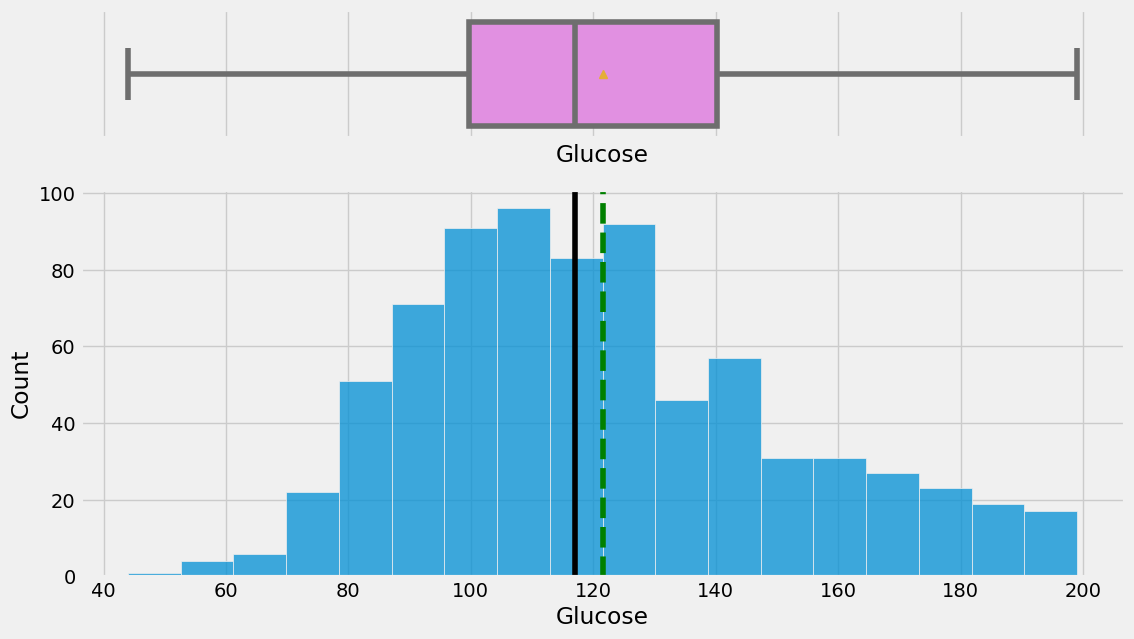

Univariates of  BloodPressure


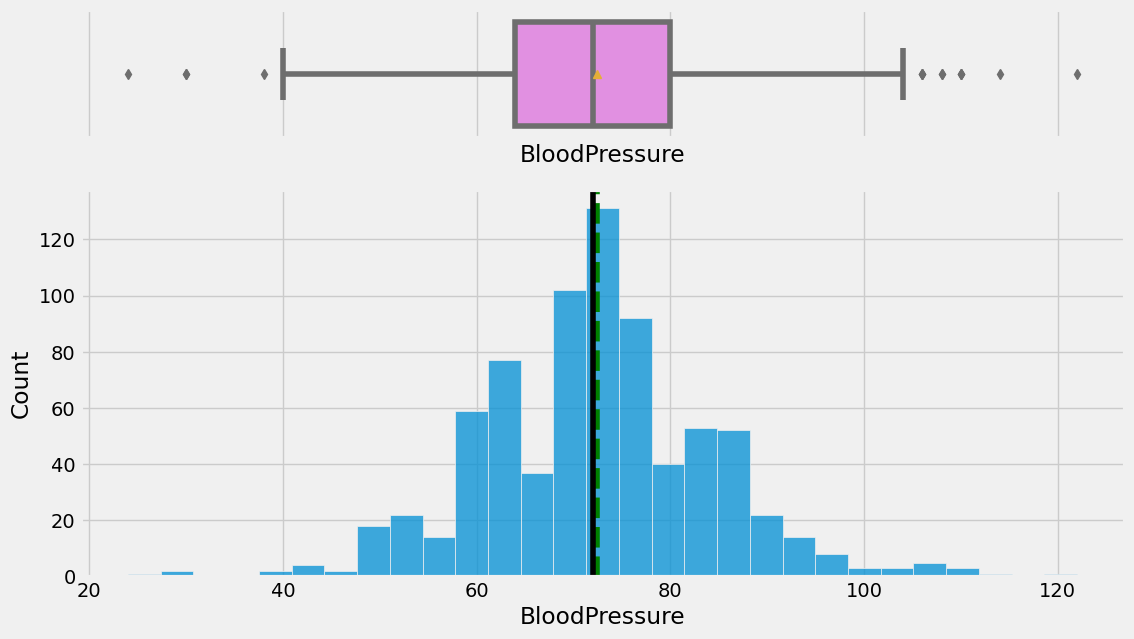

Univariates of  SkinThickness


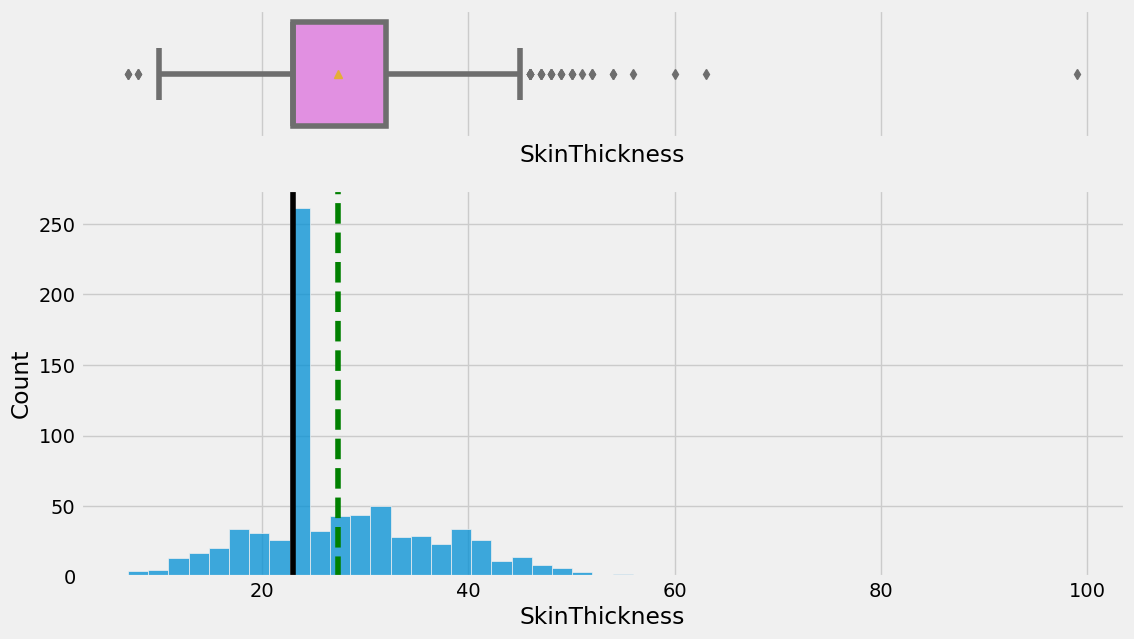

Univariates of  Insulin


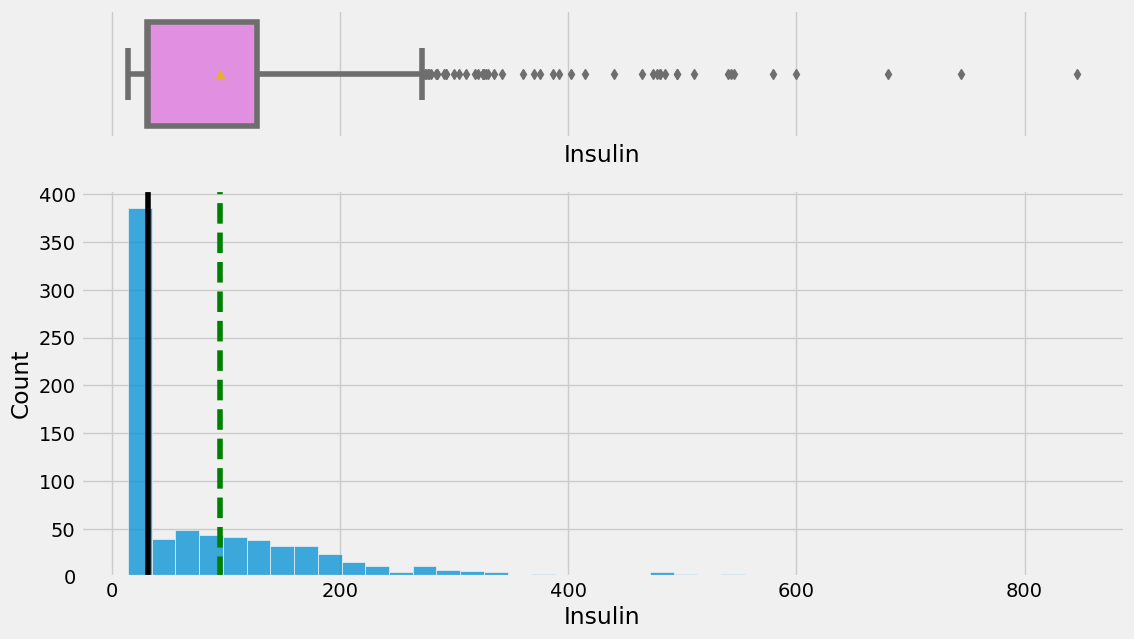

Univariates of  BMI


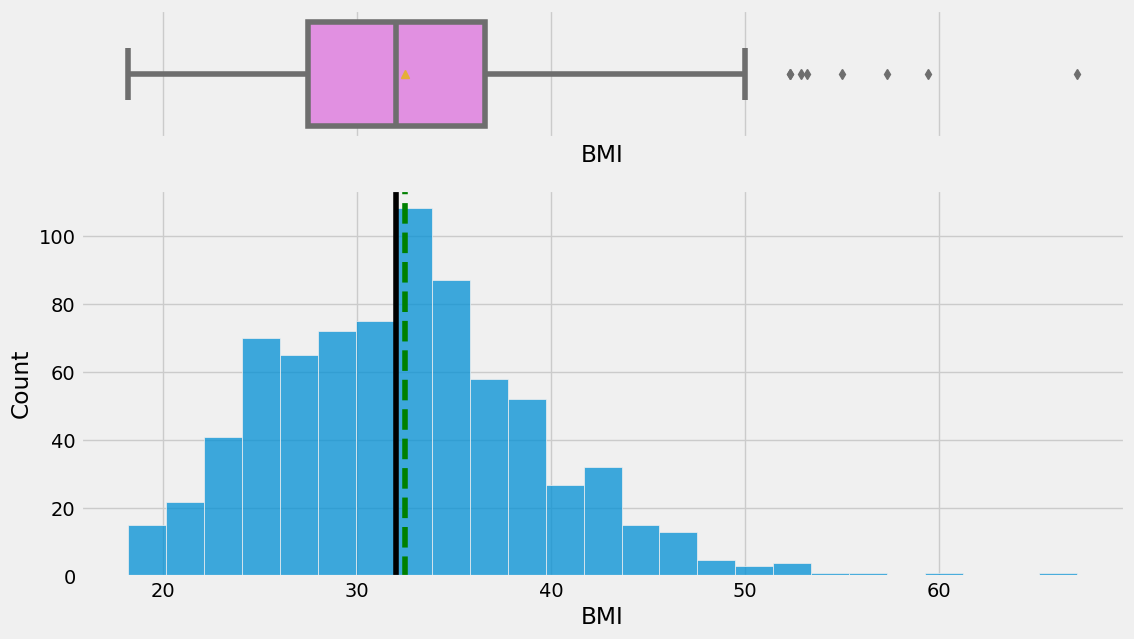

Univariates of  DiabetesPedigreeFunction


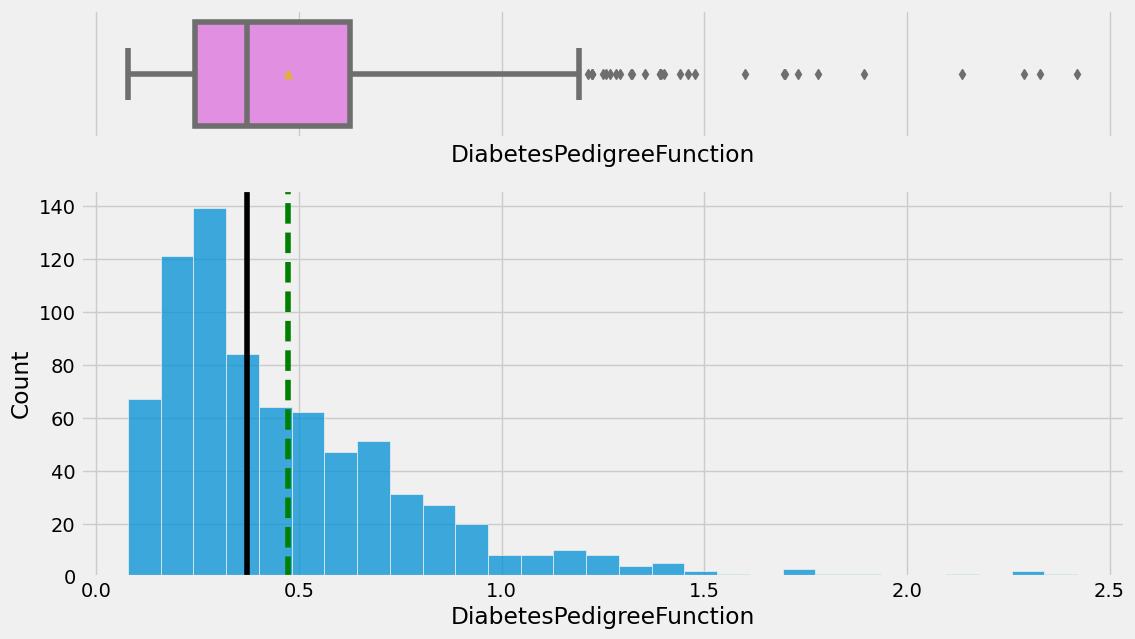

Univariates of  Age


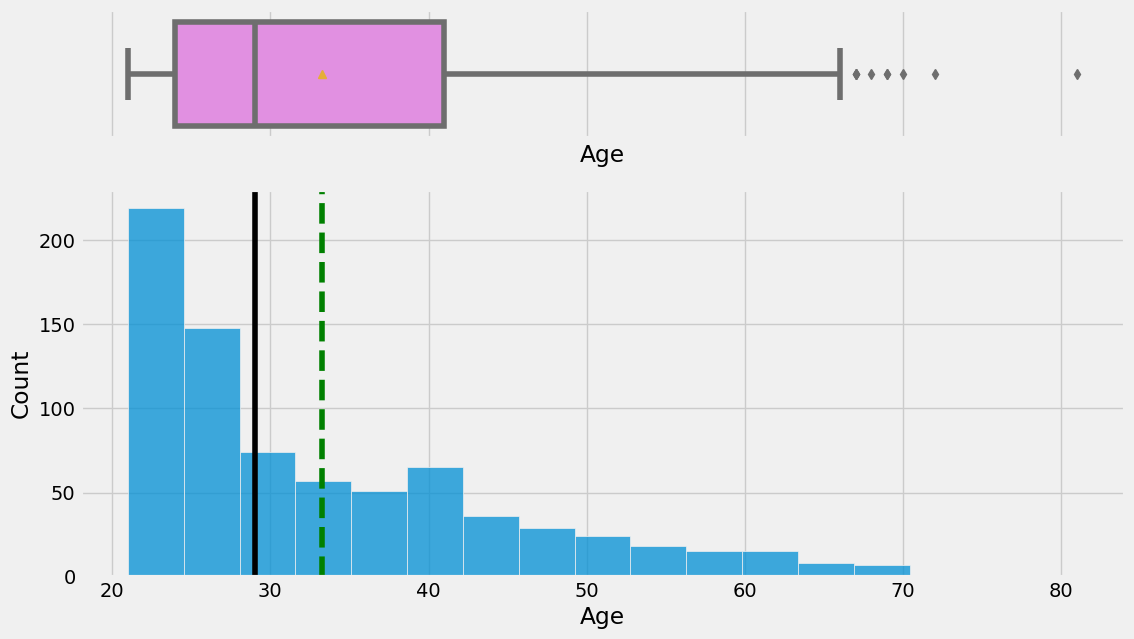

Univariates of  Outcome


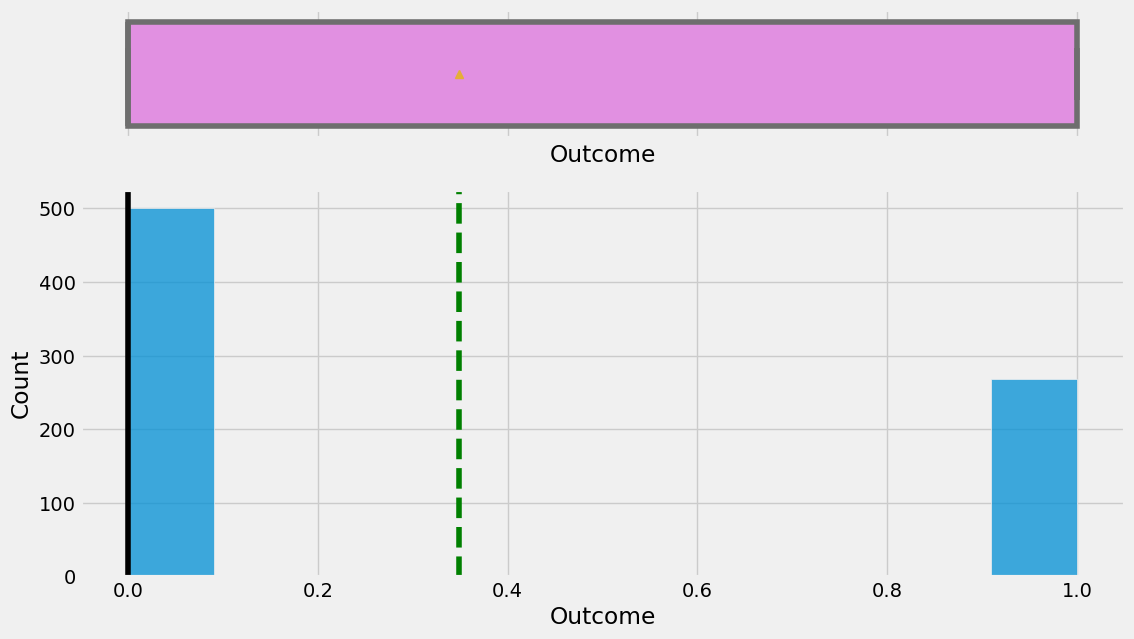

In [22]:
for col in df.select_dtypes(exclude='O').columns:
    boxpolot_histplot(data=df, feature=col)

**Observations**
1. Pregnancies has some suspect outliers which have to be looked upon
2. Skin thickness also has some suspect outliers which need to be taken care of 
3. Insulin is highly right skewed aand may need to be engineered
4. Diabetes pedigree function is also highly right skewed and needs to be engineered.
5. Outcome is highly imbalanced and may need balancing.

##### BIVARIATES-NUMERICAL vs CATEGORICAL

In [23]:
def catnums(data, feature1, feature2):
    print("Bivariate Barchart between {0} and {1}".format(feature1, feature2))
    data.groupby(feature1)[feature2].mean().plot(kind='bar',color='orange')
    plt.show()

Bivariate Barchart between Outcome and Pregnancies


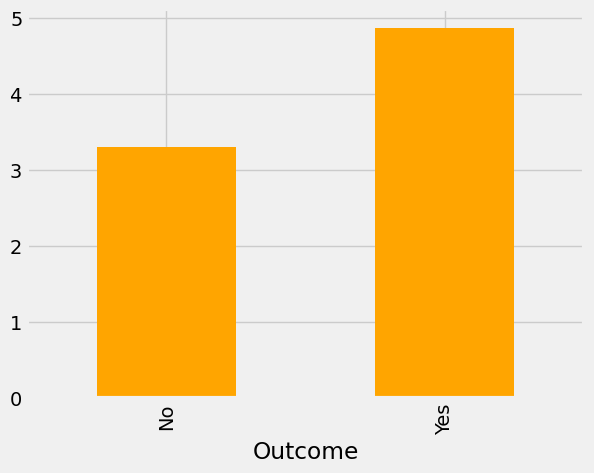

Bivariate Barchart between Outcome and Glucose


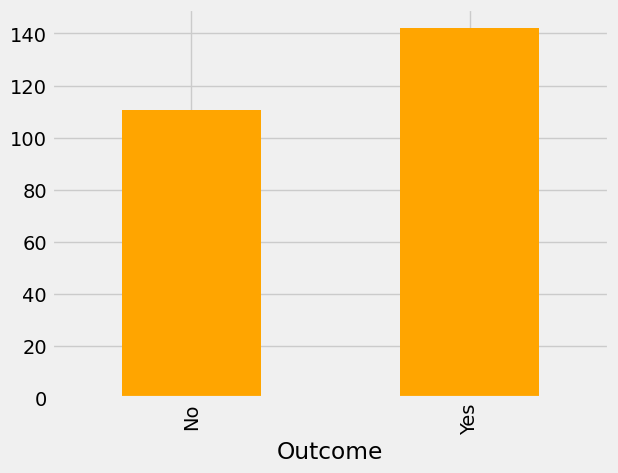

Bivariate Barchart between Outcome and BloodPressure


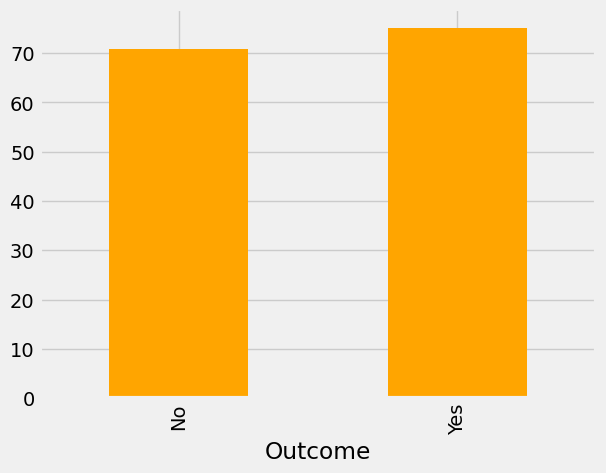

Bivariate Barchart between Outcome and SkinThickness


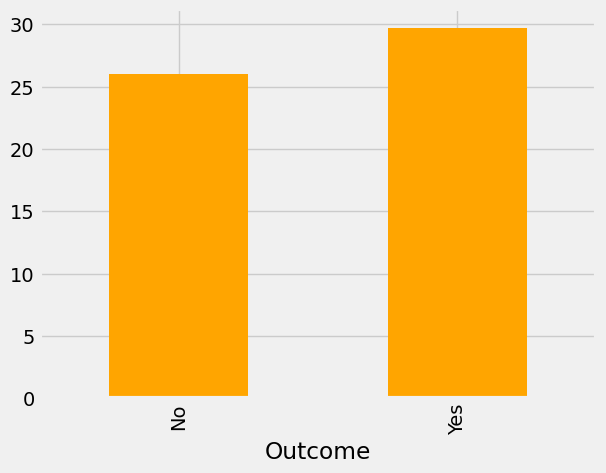

Bivariate Barchart between Outcome and Insulin


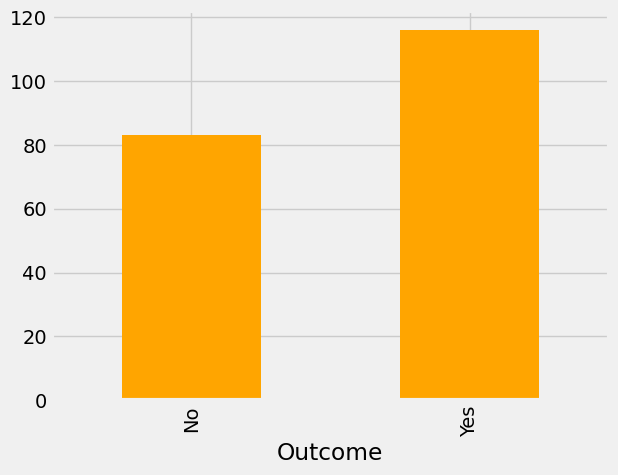

Bivariate Barchart between Outcome and BMI


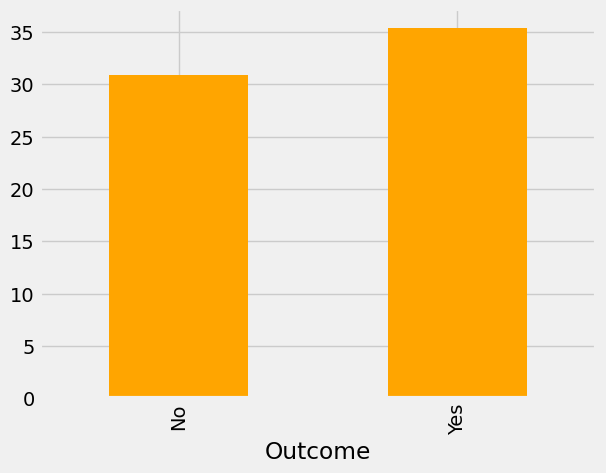

Bivariate Barchart between Outcome and DiabetesPedigreeFunction


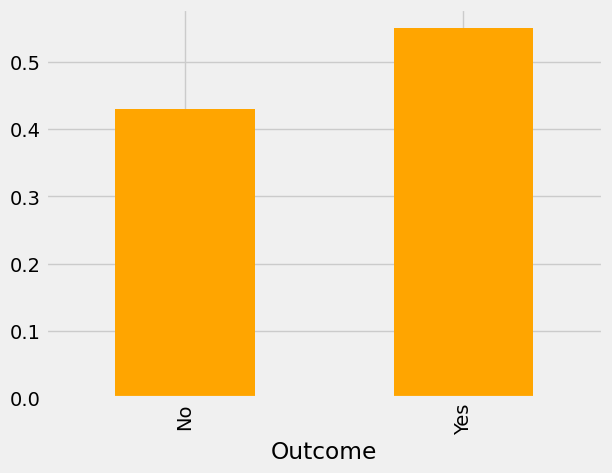

Bivariate Barchart between Outcome and Age


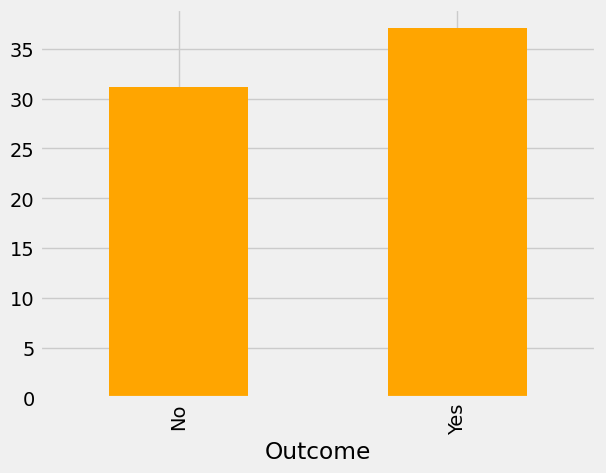

In [24]:
for col in data.select_dtypes(exclude='O').columns:
    catnums(data=data, feature1='Outcome', feature2=col)

**Observations**
Woman with higher pregnancies, higher diabetes predigree functions and Insulin use are more likely to be diabetic

##### BIVARIATES-NUMERICAL vs NUMERICAL

In [25]:
def lineplot_scatterplot(data, feature1, feature2):
    print("Bivariates between {0} and {1}".format(feature1, feature2))
    plt.figure(figsize=(16,7))
    plt.subplot(1,2,1)
    sns.lineplot(data=data, x=feature1, y=feature2, color='green')
    plt.subplot(1,2,2)
    sns.scatterplot(data=data, x=feature1, y=feature2, color='blue')
    plt.show()

Bivariates between Pregnancies and Pregnancies


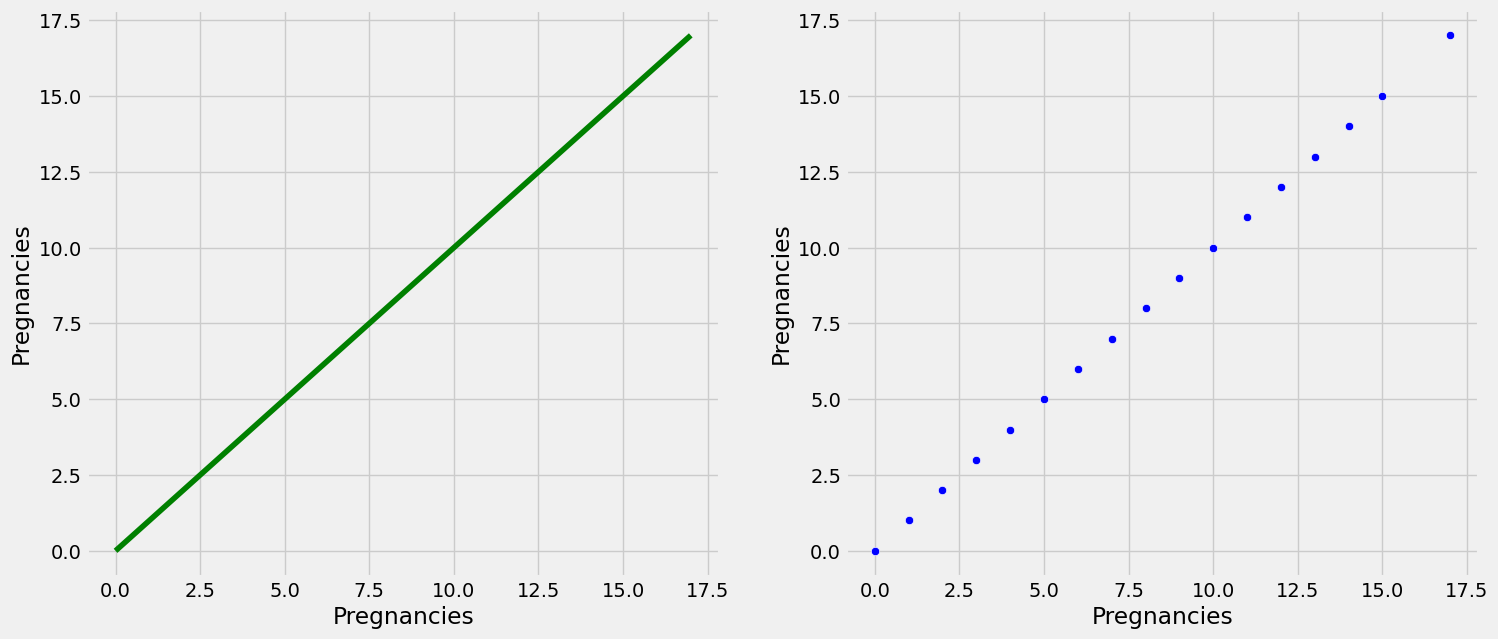

Bivariates between Pregnancies and Glucose


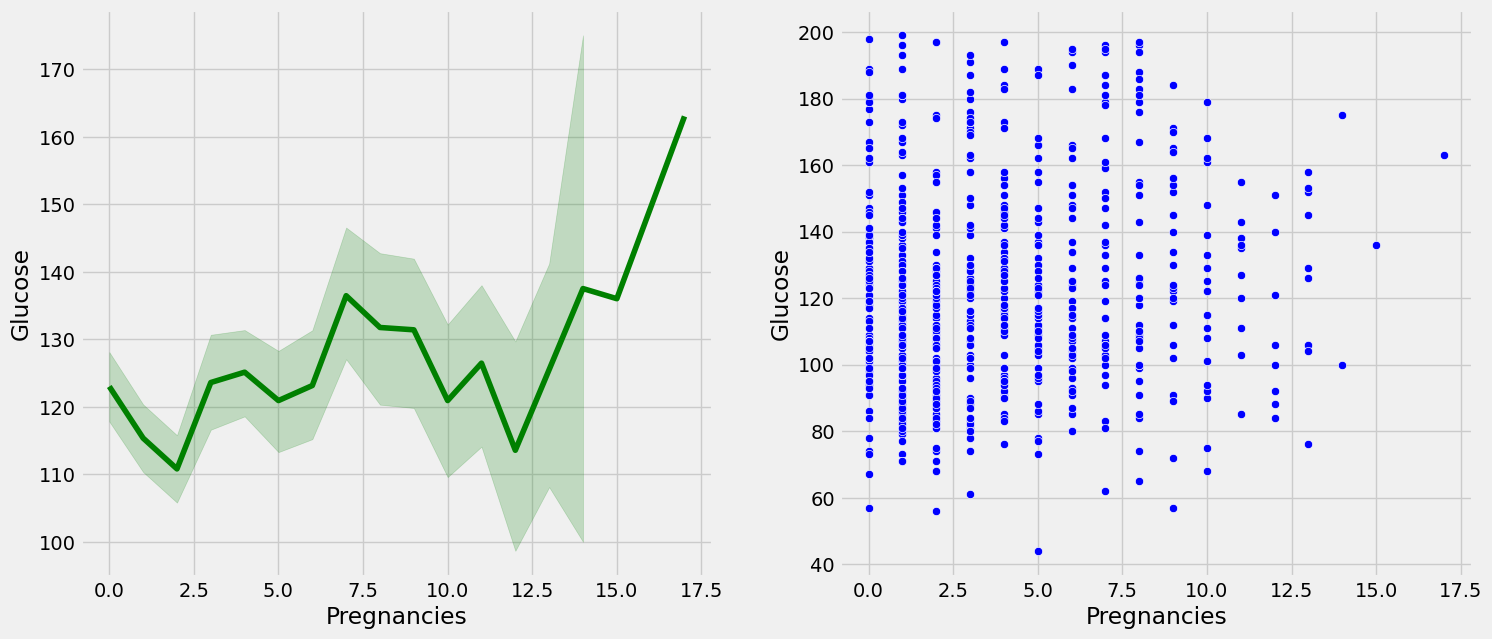

Bivariates between Pregnancies and BloodPressure


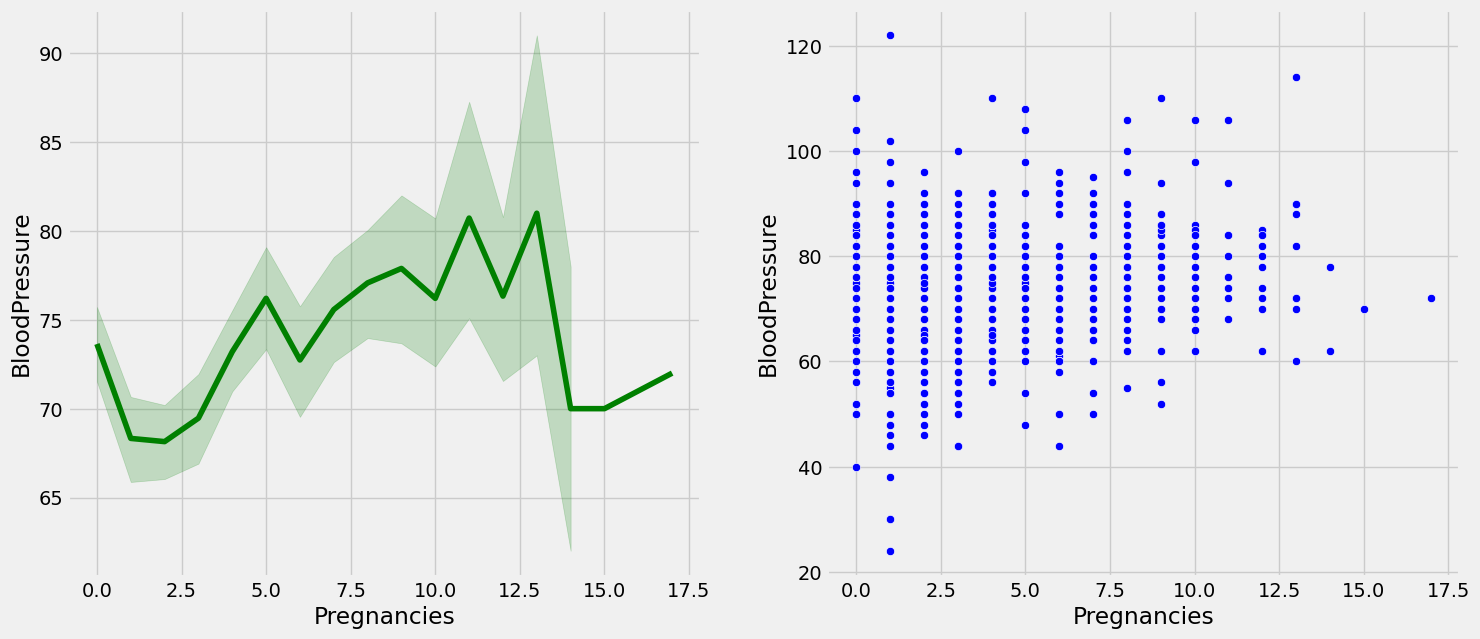

Bivariates between Pregnancies and SkinThickness


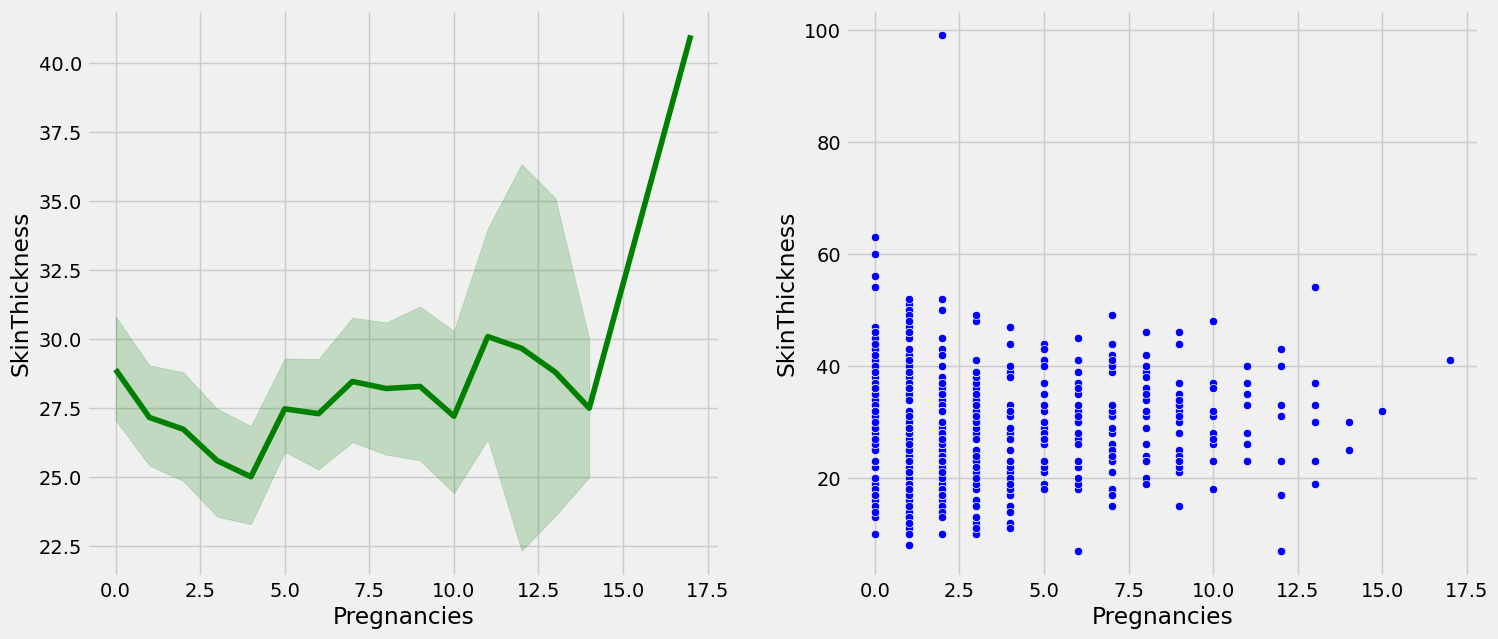

Bivariates between Pregnancies and Insulin


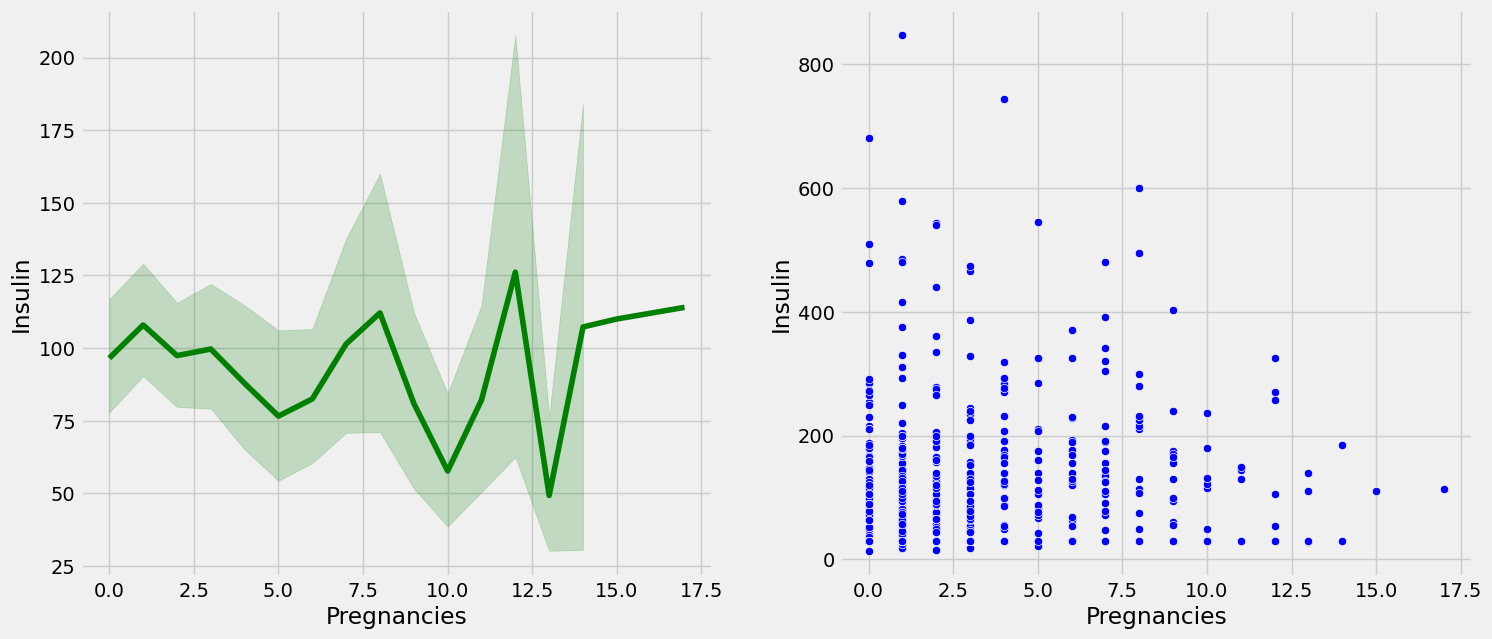

Bivariates between Pregnancies and BMI


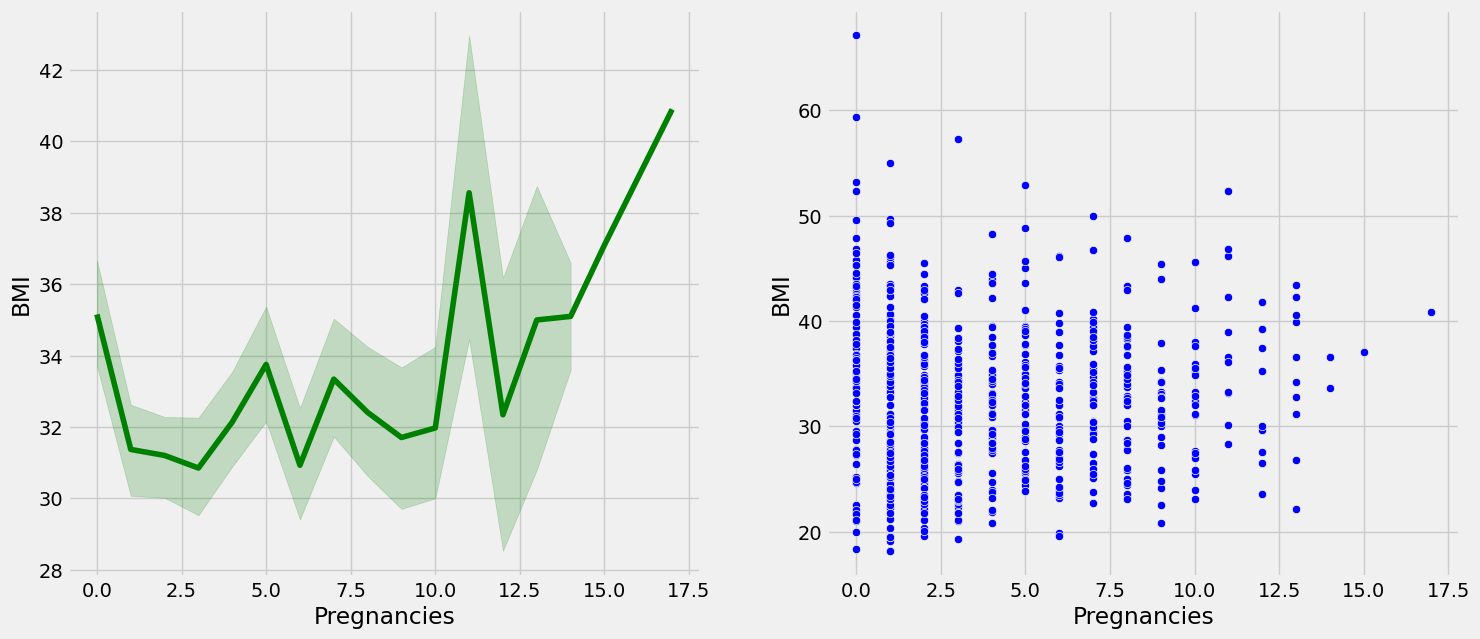

Bivariates between Pregnancies and DiabetesPedigreeFunction


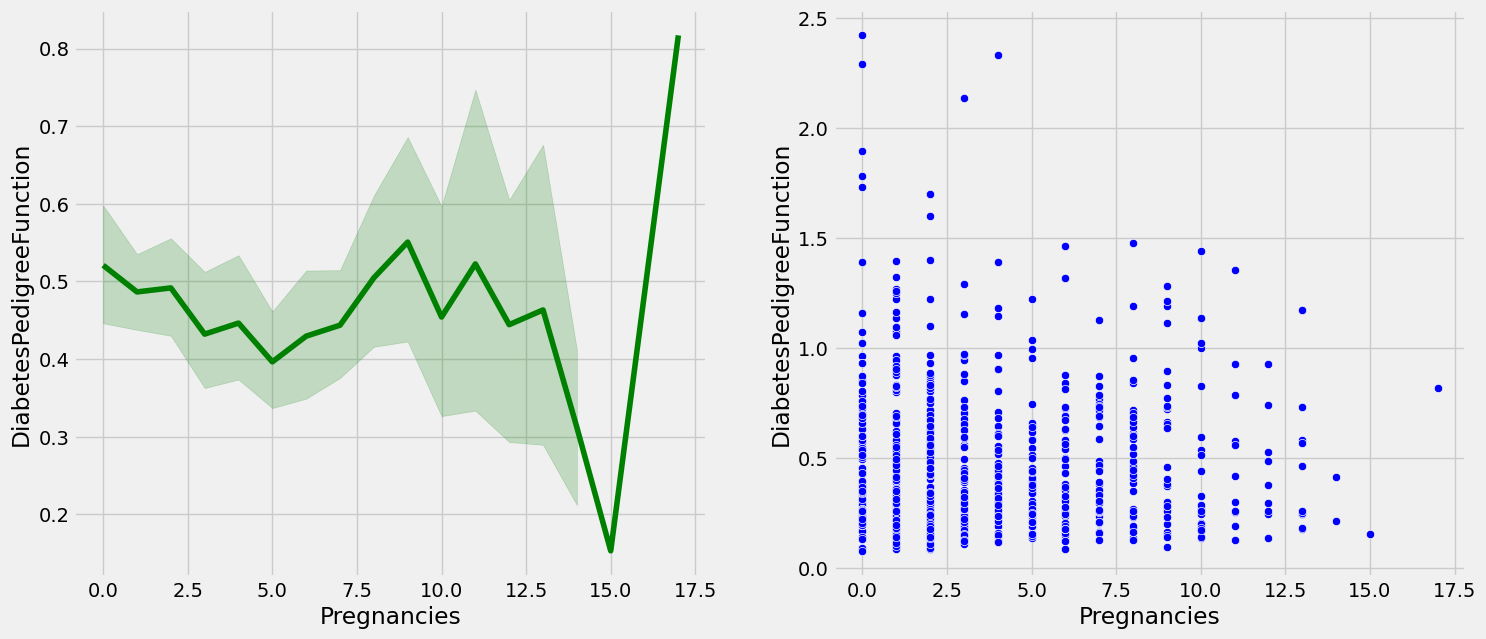

Bivariates between Pregnancies and Age


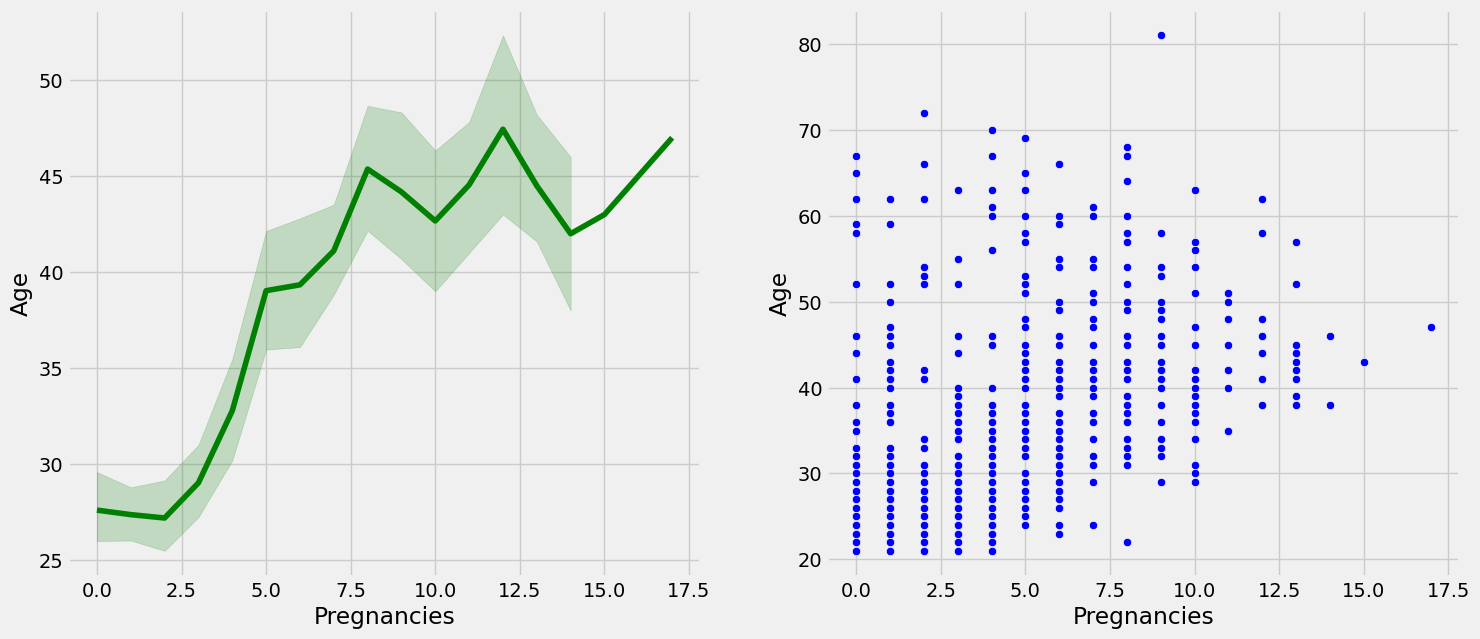

In [26]:
for col in data.select_dtypes(exclude='O').columns:
    lineplot_scatterplot(data=data, feature1='Pregnancies', feature2=col)
    
    

##### MULTIVARIATE CHARTS

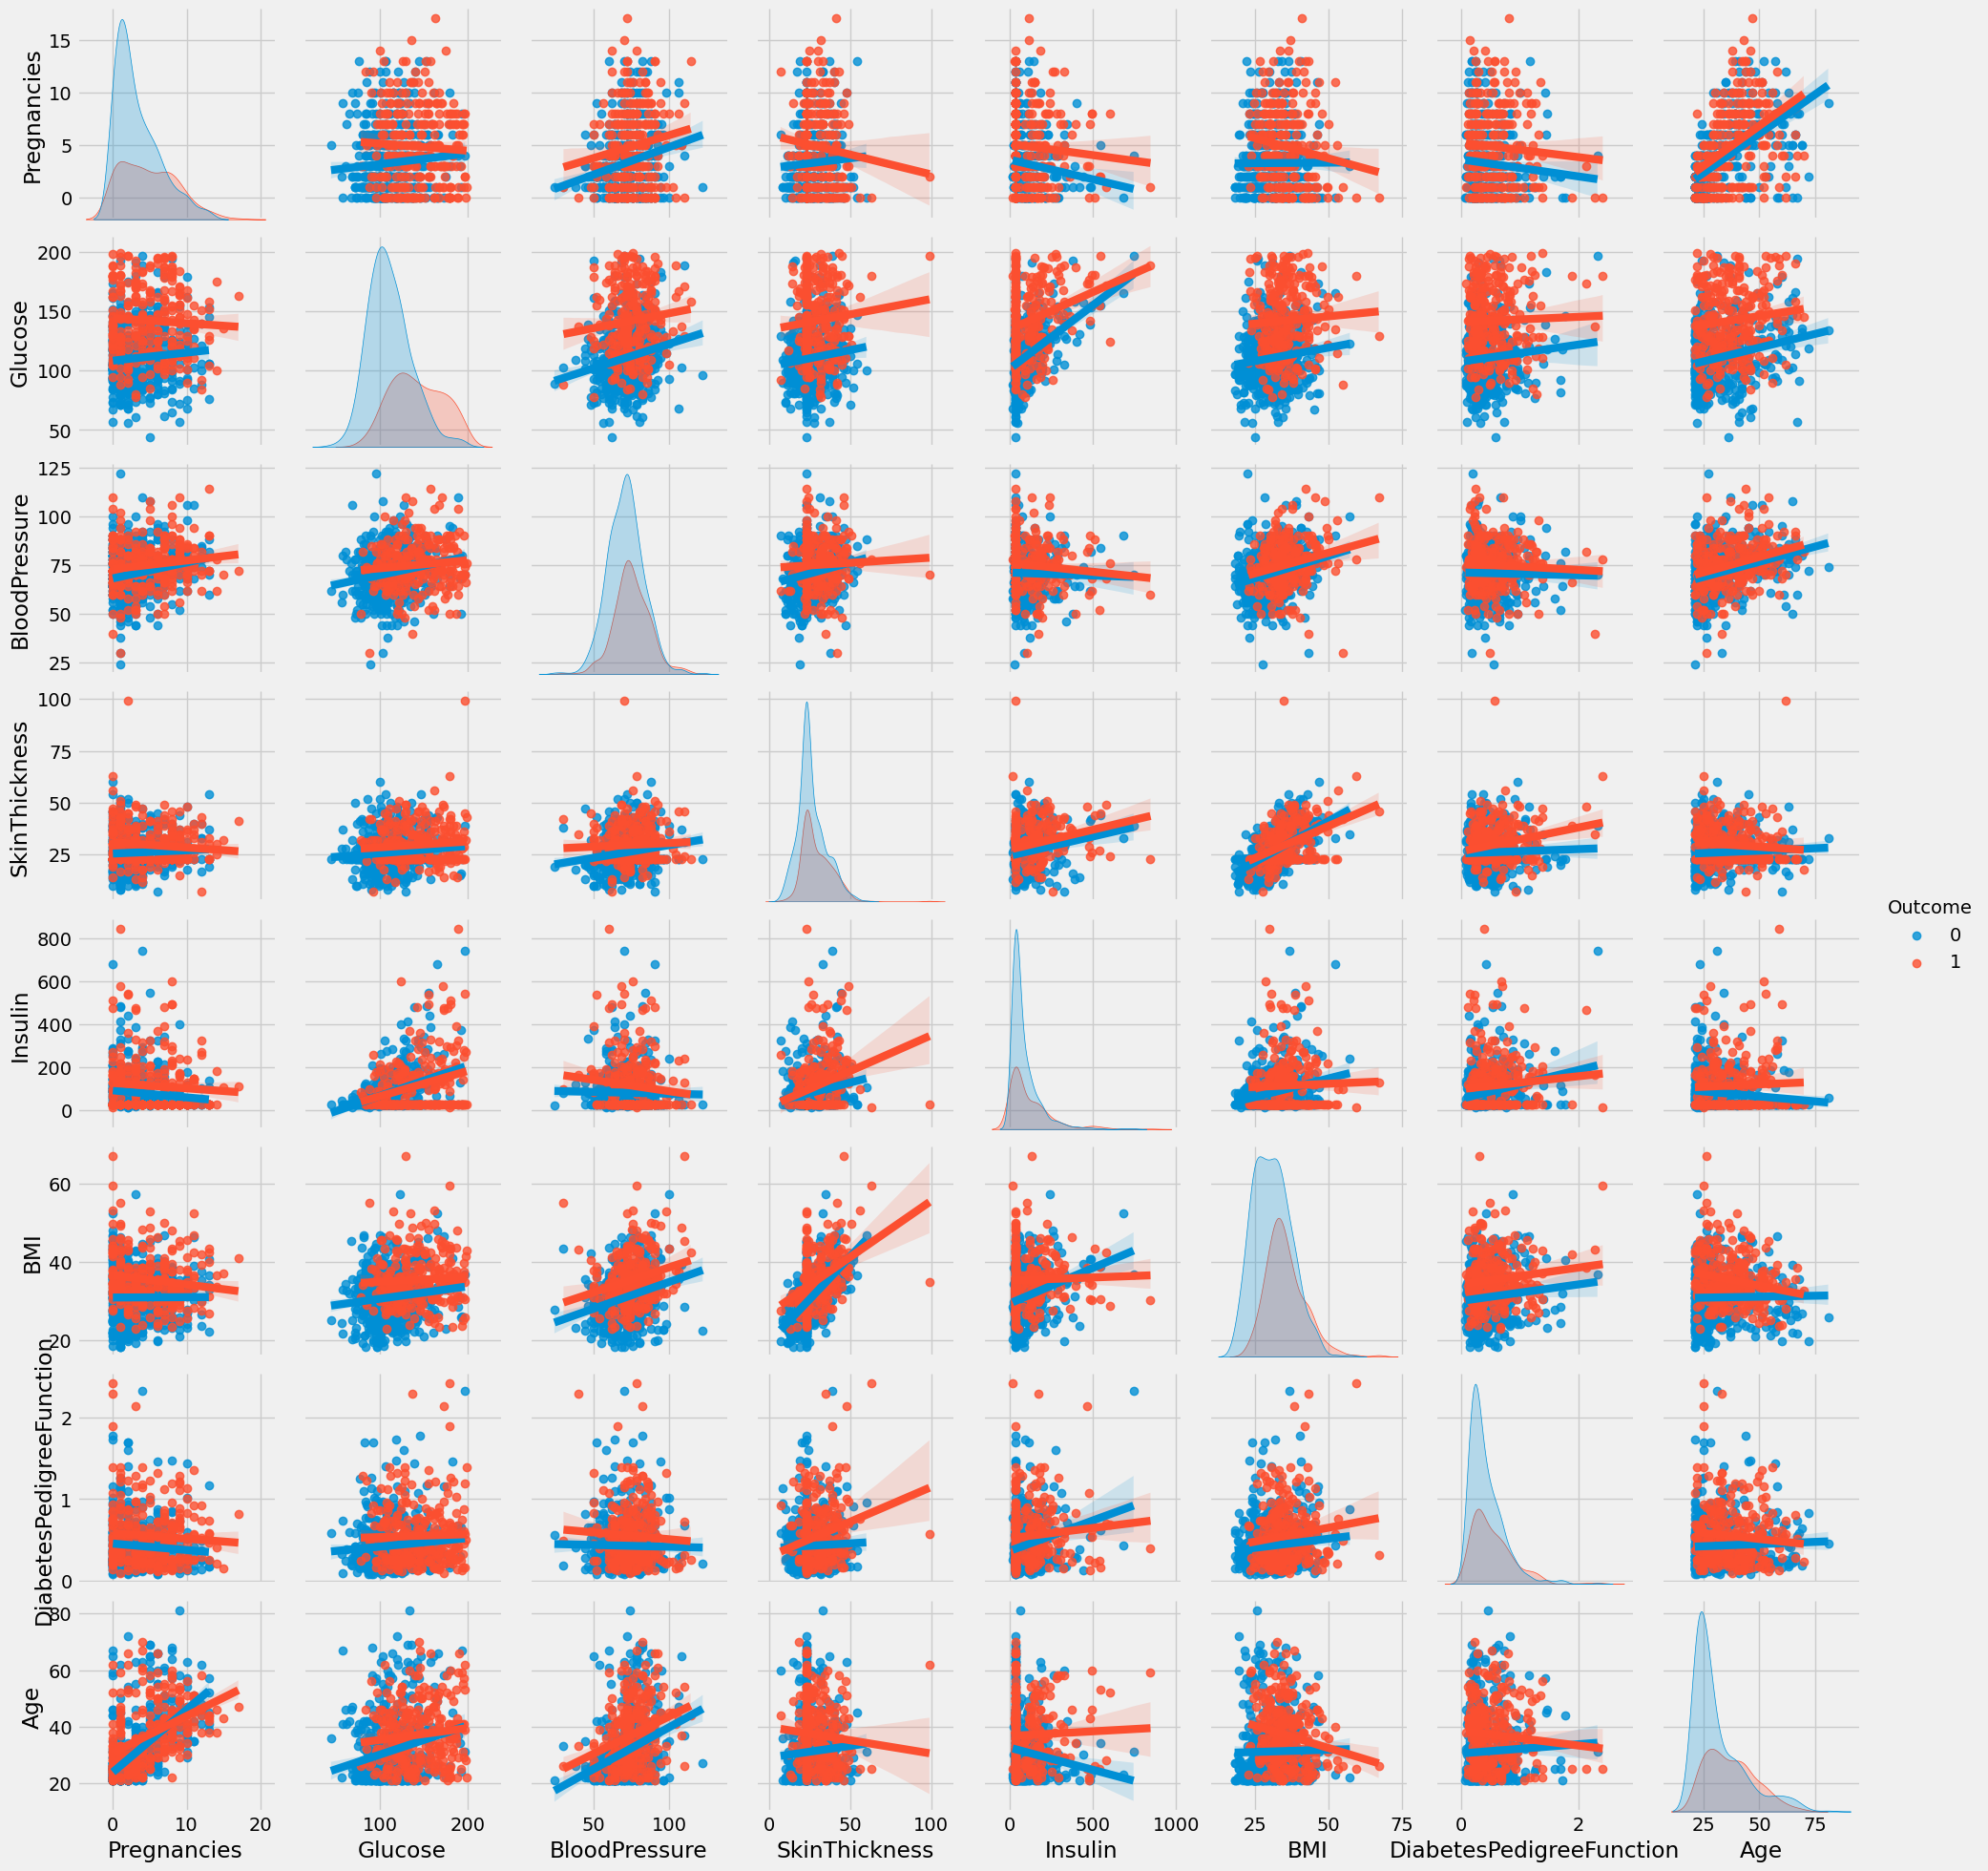

In [27]:
sns.pairplot(data=df, hue='Outcome', kind='reg')

##### Correlations and Heatmaps

In [28]:
df[df.columns[:]].corr()['Outcome']

Pregnancies                 0.221898
Glucose                     0.492782
BloodPressure               0.165723
SkinThickness               0.189065
Insulin                     0.148457
BMI                         0.312249
DiabetesPedigreeFunction    0.173844
Age                         0.238356
Outcome                     1.000000
Name: Outcome, dtype: float64

<AxesSubplot:>

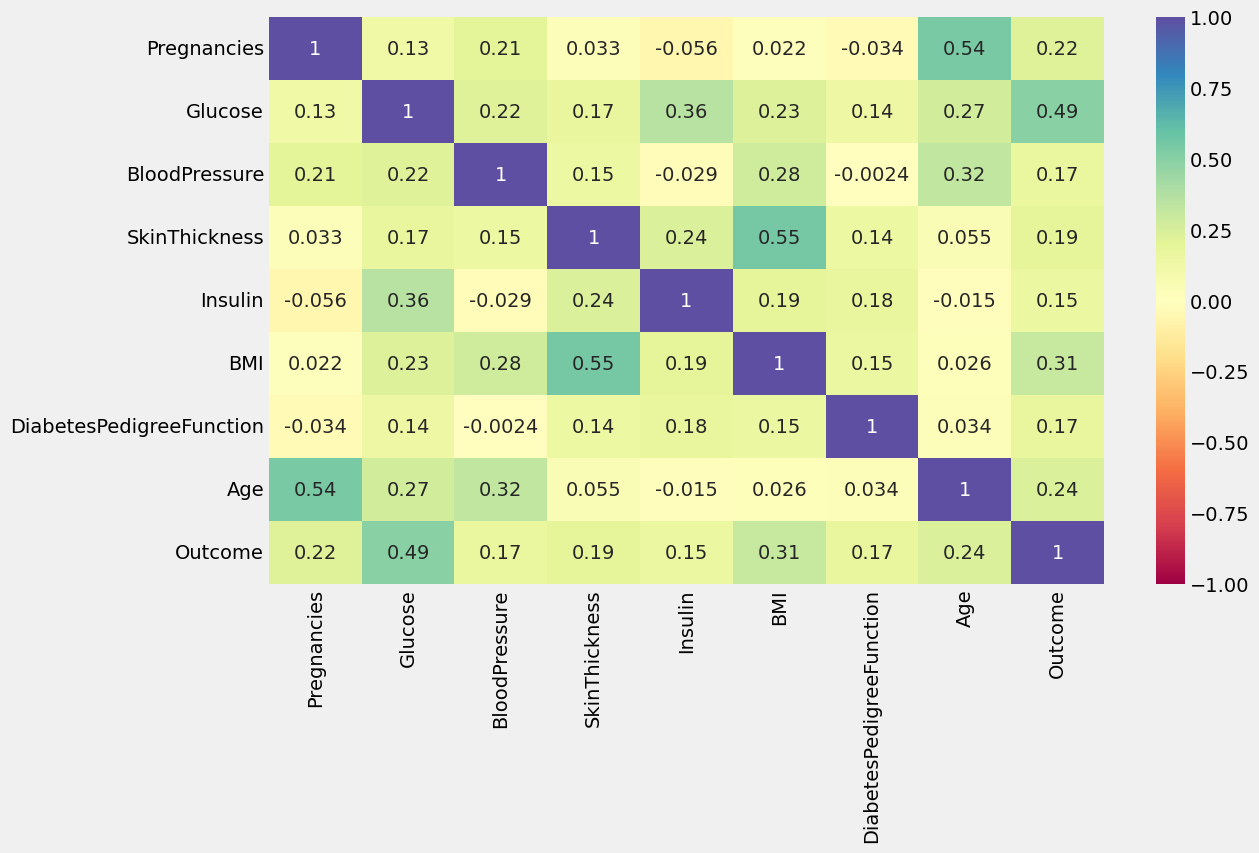

In [29]:
plt.figure(figsize=(12,7))
sns.heatmap(df.corr(), annot=True, cmap='Spectral', vmax=+1, vmin=-1)

**Observations**
Glucose and BMI seem to be strongest predictors of Diabetes

In [30]:
%%writefile eda.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import streamlit as st
st.set_option('deprecation.showPyplotGlobalUse', False)
st.title("The EDA Page")

def main():
    st.sidebar.subheader("Please choose the plot")
    data=pd.read_csv('data.csv')
    # drop the redundant column
    data=data.drop('Unnamed: 0', axis=1)
    # treat the nulls
    zerofiller=lambda x: x.replace(0, x.median())
    cols=data.columns[1:6]
    data[cols]=data[cols].apply(zerofiller, axis=0)
    #encode categoricals
    df=data.copy()
    d={'Yes':1, 'No':0}
    df['Outcome']=df['Outcome'].map(d)
    
    def histograms(data):
        st.subheader('Univariate Histogram')
        data.hist()
        plt.tight_layout()
        st.pyplot()
    def barchart(data, feature):
        st.subheader("Barchart of Categoricals")
        ax=sns.countplot(data=data, x=feature, color='green')
        for p in ax.patches:
            x=p.get_bbox().get_points()[:,0]
            y=p.get_bbox().get_points()[1,1]
            ax.annotate("{:.2g}%".format(100.*y/len(data)), (x.mean(),y), ha='center' , va='bottom')                                  
        st.pyplot()
        
    def heatmap(data):
        st.subheader("The Heatmap")
        plt.figure(figsize=(12,7))
        sns.heatmap(df.corr(), annot=True, cmap='Spectral', vmax=+1, vmin=-1)
        st.pyplot()
        
    plot=st.sidebar.selectbox('Choose Plot',('Histograms', 'Barchart', 'Heatmap'))
    if st.sidebar.button("PLOT"):
        if plot=='Histograms':
            histograms(df)
        if plot=='Barchart':
            barchart(data=df, feature='Outcome')
        if plot=='Heatmap':
            heatmap(data=df)
        
if __name__=='__main__':
    main()
        
        

    
    
    

Overwriting eda.py


# step 4.preprocess the data for modelling

In [31]:
def preprocessing (df,label):
    x=df.drop(label,axis=1)
    y=df[label]
    from imblearn.over_sampling import SMOTE
    sm=SMOTE()
    x,y=sm.fit_resample(x,y)
    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=42)
    return x_train,x_test,y_train,y_test


In [32]:
x_train,x_test,y_train,y_test =preprocessing(df,'Outcome')

In [33]:
#scale the features
sc=StandardScaler()
x_train=sc.fit_transform(x_train)
x_test=sc.transform(x_test)


In [34]:

print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)

(700, 8) (700,) (300, 8) (300,)


In [35]:

# function to print metrics
def print_metrics(y_test,y_pred,model):
    print('Metrics for the model',model)
    print(' ')
    print("Accuracy score is ",accuracy_score(y_test,y_pred))
    print(' ')
    print("recall score is ",recall_score(y_test,y_pred))
    print(' ')
    print('precision score is',precision_score(y_test,y_pred))
    print(' ')
    print('f1 score is', f1_score(y_test,y_pred))
    print(' ')
    print(' Roc score is ',roc_auc_score(y_test,y_pred))
    print(' ')
    print('Confusion matrix \n', confusion_matrix(y_test,y_pred))
    print(' ')
    print('Classification report \n',classification_report(y_test,y_pred))

In [83]:

def plot_metrics(clf,x_test,y_test,model):
    print('plots for model',model)
    plot_confusion_matrix(clf,x_test,y_test,display_labels=[0,1])
    print('')
    plot_roc_curve(clf,x_test,y_test)
    print('')
    plot_precision_recall_curve(clf,x_test,y_test)

In [37]:
  #create and fit a KNN model

knn=KNeighborsClassifier()
knn.fit(x_train,y_train)
y_pred=knn.predict(x_test)
print_metrics(y_test,y_pred,'KNN')

Metrics for the model KNN
 
Accuracy score is  0.7766666666666666
 
recall score is  0.9006622516556292
 
precision score is 0.723404255319149
 
f1 score is 0.8023598820058998
 
 Roc score is  0.7758344815325127
 
Confusion matrix 
 [[ 97  52]
 [ 15 136]]
 
Classification report 
               precision    recall  f1-score   support

           0       0.87      0.65      0.74       149
           1       0.72      0.90      0.80       151

    accuracy                           0.78       300
   macro avg       0.79      0.78      0.77       300
weighted avg       0.79      0.78      0.77       300



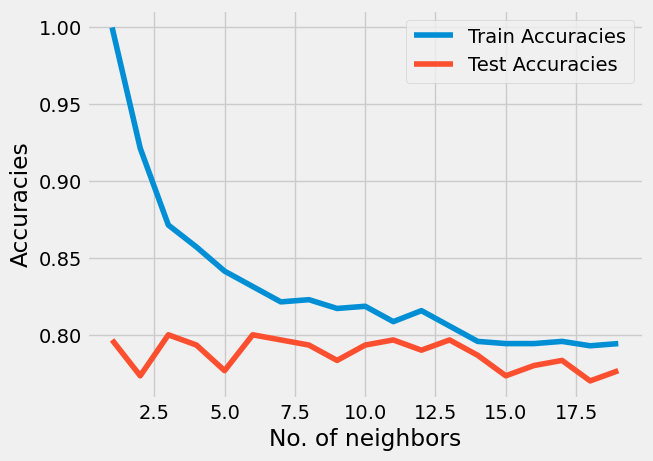

In [38]:
neighbors=np.arange(1,20)
train_accuracies=np.empty(len(neighbors))
test_accuracies=np.empty(len(neighbors))

# enumerate along the neighbors
for i,k in enumerate(neighbors):
    knn=KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train,y_train)
    train_accuracies[i]=knn.score(x_train,y_train)
    test_accuracies[i]=knn.score(x_test,y_test)

# plot the model complexity curves

plt.plot(neighbors,train_accuracies,label='Train Accuracies')
plt.plot(neighbors,test_accuracies,label='Test Accuracies')
plt.legend()
plt.xlabel('No. of neighbors')
plt.ylabel('Accuracies')
plt.show()

In [39]:
# Lets select the best model based on the f1_score and optimize it
clfs = {'KNN' : KNeighborsClassifier(), 'NaiveBayes':GaussianNB(), 'Logregs':LogisticRegression(), 'Decision Tree':DecisionTreeClassifier(), 'Random Forest':RandomForestClassifier(), 'Ada Boost':AdaBoostClassifier(), 'Gradient Boosting': GradientBoostingClassifier(), 'XG Boost': XGBClassifier(), 'SVM': SVC()}
models_report = pd.DataFrame(columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])
for clf, clf_name in list(zip(clfs.values(), clfs.keys())):
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    print(f'Fitting the Model - {clf_name}')
    t = {'Model':clf_name, 'Accuracy': accuracy_score(y_test, y_pred), 'Precision' : precision_score(y_test, y_pred), 'Recall' : recall_score(y_test, y_pred), 'F1 Score' : recall_score(y_test, y_pred)}
    models_report = models_report.append(t, ignore_index = True)
models_report = models_report.sort_values(by = 'F1 Score', ascending = False)
models_report

Fitting the Model - KNN
Fitting the Model - NaiveBayes
Fitting the Model - Logregs
Fitting the Model - Decision Tree
Fitting the Model - Random Forest
Fitting the Model - Ada Boost
Fitting the Model - Gradient Boosting
Fitting the Model - XG Boost
Fitting the Model - SVM


,Model,Accuracy,Precision,Recall,F1 Score
0,KNN,0.776667,0.723404,0.900662,0.900662
4,Random Forest,0.796667,0.767857,0.854305,0.854305
8,SVM,0.793333,0.766467,0.847682,0.847682
5,Ada Boost,0.763333,0.738095,0.821192,0.821192
7,XG Boost,0.766667,0.742515,0.821192,0.821192
6,Gradient Boosting,0.780000,0.767296,0.807947,0.807947
3,Decision Tree,0.740000,0.718563,0.794702,0.794702
2,Logregs,0.766667,0.768212,0.768212,0.768212
1,NaiveBayes,0.766667,0.795620,0.721854,0.721854


Random forest has performed the best.so lets optimize this model

In [40]:
rfc = RandomForestClassifier()
rfc.fit(x_train,y_train)
y_pred = rfc.predict(x_test)
print_metrics(y_test,y_pred,'RFC')


Metrics for the model RFC
 
Accuracy score is  0.81
 
recall score is  0.8609271523178808
 
precision score is 0.7831325301204819
 
f1 score is 0.8201892744479494
 
 Roc score is  0.8096582070314235
 
Confusion matrix 
 [[113  36]
 [ 21 130]]
 
Classification report 
               precision    recall  f1-score   support

           0       0.84      0.76      0.80       149
           1       0.78      0.86      0.82       151

    accuracy                           0.81       300
   macro avg       0.81      0.81      0.81       300
weighted avg       0.81      0.81      0.81       300



In [51]:
param_grid={
    'n_estimators':[100,150,200,250],
    'min_samples_leaf':range(1,10,1),
    'min_samples_split':range(2,20,2),
    'max_depth':[2,4,'auto'],
    'max_features':['sqrt','log2'],
    'criterion':['gini','entropy']
}

n_folds = 5
cv=GridSearchCV(estimator= rfc,param_grid= param_grid , cv =n_folds,n_jobs = -1,  verbose =3 ,return_train_score= False)
cv.fit(x_train,y_train)

Fitting 5 folds for each of 3888 candidates, totalling 19440 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 'auto'],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': range(1, 10),
                         'min_samples_split': range(2, 20, 2),
                         'n_estimators': [100, 150, 200, 250]},
             verbose=3)

In [52]:
cv.best_score_

0.8

In [53]:
cv.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=4, max_features='sqrt',
                       min_samples_leaf=5, min_samples_split=8)

In [60]:
rfc_tuned = RandomForestClassifier(criterion='entropy', max_depth=4, max_features='sqrt',
                       min_samples_leaf=5, min_samples_split=8)


In [62]:
rfc_tuned.fit(x_train,y_train)


RandomForestClassifier(criterion='entropy', max_depth=4, max_features='sqrt',
                       min_samples_leaf=5, min_samples_split=8)

In [64]:
y_pred =rfc_tuned.predict(x_test)

In [65]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.85      0.70      0.76       149
           1       0.75      0.87      0.80       151

    accuracy                           0.79       300
   macro avg       0.80      0.79      0.78       300
weighted avg       0.80      0.79      0.78       300



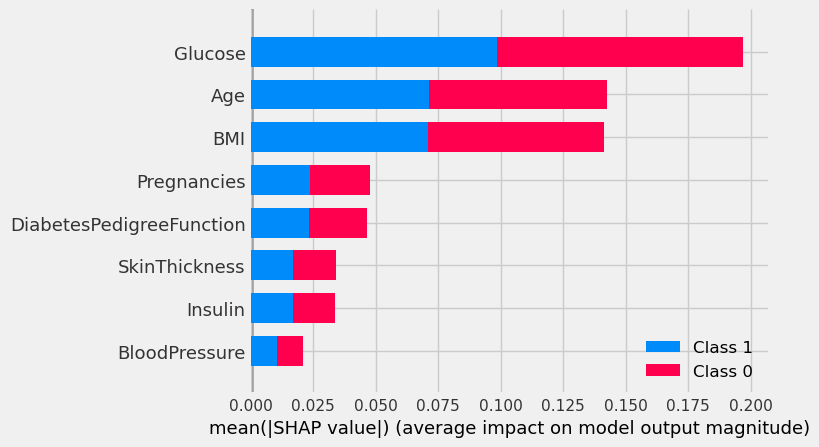

In [72]:
import shap 
x=df.drop('Outcome',axis=1)
value=shap.TreeExplainer(rfc_tuned).shap_values(x_test)
shap.summary_plot(value,x_train,plot_type='bar',feature_names=.columns)

# step 8: pickle and save the model as pipline

In [87]:
from sklearn.pipeline import Pipeline
sc = StandardScaler()
rfc_tuned=rfc_tuned
steps = [('scaler',sc), ('rfc_tuned',rfc_tuned)]
pipeline = Pipeline(steps)
x_train ,x_test ,y_train,y_test = preprocessing(df , label = 'Outcome')
pipeline.fit(x_train,y_train)
y_pred = pipeline.predict(x_test)
#plot_metrics(pipeline, x_test, y_test,'Pipeline')
print_metrics(y_test , y_pred , 'Pipeline')


Metrics for the model Pipeline
 
Accuracy score is  0.77
 
recall score is  0.8410596026490066
 
precision score is 0.7383720930232558
 
f1 score is 0.7863777089783281
 
 Roc score is  0.7695230899151074
 
Confusion matrix 
 [[104  45]
 [ 24 127]]
 
Classification report 
               precision    recall  f1-score   support

           0       0.81      0.70      0.75       149
           1       0.74      0.84      0.79       151

    accuracy                           0.77       300
   macro avg       0.78      0.77      0.77       300
weighted avg       0.78      0.77      0.77       300



plots for model Pipeline




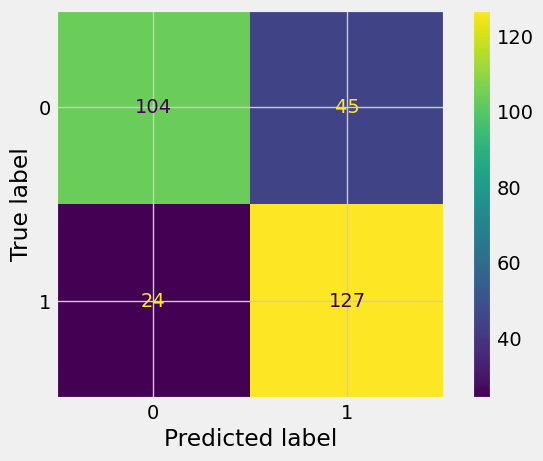

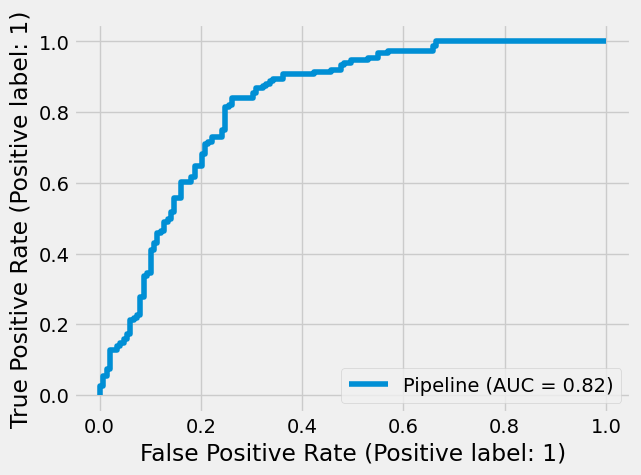

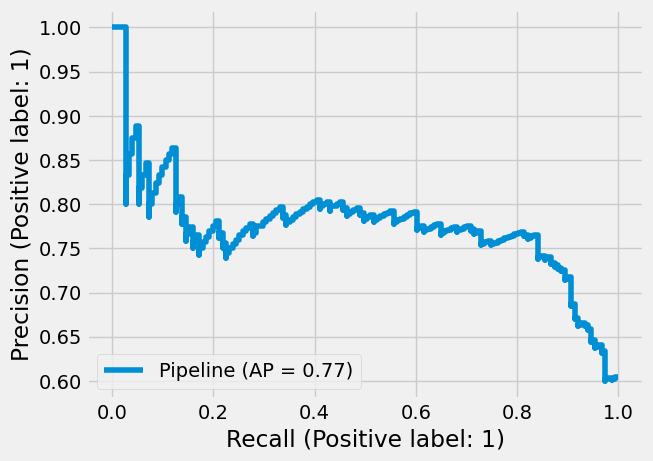

In [88]:
plot_metrics(pipeline, x_test, y_test,'Pipeline')

In [99]:
# save the pipline as pickle file
import pickle
model = open('rfc.pickle','wb')
pickle.dump(pipeline,model)
model.close()

# step9:  deploy the model as streamlit file

%%writefile app.py
import streamlit as st
st.title('Medical Diagnostic web app')
st.subheader("Is the patient Diabetic?")


#steps
import pandas as pd
import pickle
from sklearn.preprocessing import StandardScaler

import streamlit as st

# Load the pickeled model

model=open('rfc.pickle','rb')
clf=pickle.load(model)
model.close()




# step2: Get the input from the front end user
pregs=st.number_input('Pregnancies',0,17,0)
glucose=st.slider('Glucose',40,200,40)
bp=st.slider('BloodPressure',20,140,20)
skin=st.slider('SkinThickness',7.0,99.0,7.0)
insulin=st.slider('Insulin',14,850,14)
bmi=st.slider('BMI',18,67,18)
dpf=st.slider('DiabetesPedigreeFunction',0.05,2.5,0.05) 
age=st.slider('Age',20,90,20)



# step3: Collect the front end user input as model input data

data={
    'Pregnancies':pregs,
    'Glucose':glucose,
    "BloodPressure":bp,
    'SkinThickness':skin,
    'Insulin':insulin,
    'BMI':bmi,
    'DiabetesPedigreeFunction':dpf,
    'Age':age}

input_data=pd.DataFrame([data])

# step4: Get the prediction and print the result

preds=clf.predict(input_data)[0]
if st.button('Predict'):
    if preds==1:
        st.error('Diabetic')
    if preds==0:
        st.success('Non Diabetic')

In [106]:
%%writefile app.py
import streamlit as st
st.title('Medical Diagnostic web app')
st.subheader("Is the patient Diabetic?")

Overwriting app.py


In [107]:
#steps
import pandas as pd
import pickle
from sklearn.preprocessing import StandardScaler

import streamlit as st

ModuleNotFoundError: No module named 'streamlit'

In [108]:
# Load the pickeled model

model=open('rfc.pickle','rb')
clf=pickle.load(model)
model.close()


In [109]:
# step2: Get the input from the front end user
pregs=st.number_input('Pregnancies',0,17,0)
glucose=st.slider('Glucose',40,200,40)
bp=st.slider('BloodPressure',20,140,20)
skin=st.slider('SkinThickness',7.0,99.0,7.0)
insulin=st.slider('Insulin',14,850,14)
bmi=st.slider('BMI',18,67,18)
dpf=st.slider('DiabetesPedigreeFunction',0.05,2.5,0.05) 
age=st.slider('Age',20,90,20)


NameError: name 'st' is not defined

In [110]:
# step3: Collect the front end user input as model input data

data={
    'Pregnancies':pregs,
    'Glucose':glucose,
    "BloodPressure":bp,
    'SkinThickness':skin,
    'Insulin':insulin,
    'BMI':bmi,
    'DiabetesPedigreeFunction':dpf,
    'Age':age}

input_data=pd.DataFrame([data])


NameError: name 'pregs' is not defined

In [111]:
# step4: Get the prediction and print the result

preds=clf.predict(input_data)[0]
if st.button('Predict'):
    if preds==1:
        st.error('Diabetic')
    if preds==0:
        st.success('Non Diabetic')

NameError: name 'input_data' is not defined